In [8]:
import mnist
import sklearn
import matplotlib.pyplot as plt
import numpy as np

## I. Датасет:

1. Нужно скачать базу данных MNIST при помощи функции load_mnist из пакета mnist.py, используя код из методички:

Получить массивы картинок в виде массива X, а также ответов labels.


In [21]:
from mnist import load_mnist

train, validation, test = load_mnist()

X_train, y_train = train
X_validation, y_validation = validation
X_test, y_test = test

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz


2. При помощи функции matplotlib.pyplot.imshow нарисовать несколько примеров картинок из X. Чтобы картинки шли в виде массива, а не друг под другом, используйте функцию subplots.

In [20]:
X = train[0].reshape(55000, -1)

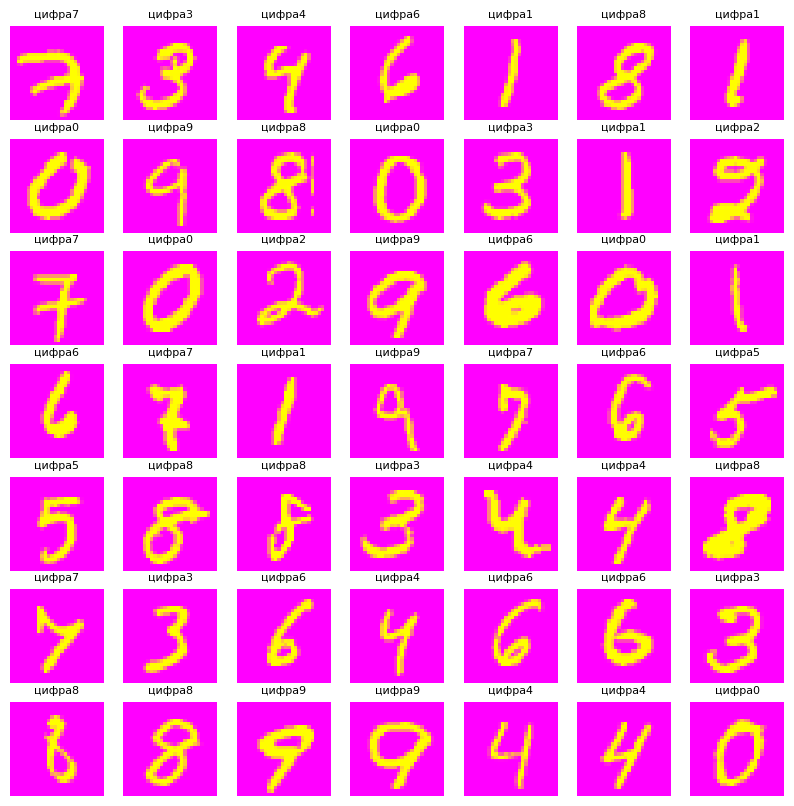

In [15]:
fig, axes = plt.subplots(7, 7, figsize=(10, 10))

for i in range(49):
    row = i // 7
    col = i % 7
    axes[row, col].imshow(X[i].reshape(28, 28), cmap='spring')
    axes[row, col].axis("off")
    axes[row, col].set_title("цифра"+ str(train[1][i]), fontsize=8)

plt.show()

## II. Алгоритм PCA

In [22]:
class my_PCA():
    def __init__(self, n_components=None): 
        self.n_components = n_components
    
    def fit(self, X):
        X_mean = np.mean(X, axis=0)
        X_c = X - X_mean
        C = np.dot(X_c.T, X_c) 
        u, s, v  = np.linalg.svd(C)
        l, V = np.linalg.eigh(C)
        return X_c, l , V

    def transform(self, X):
        return np.dot(self.X_c,V[:, :self.n_components])
    
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform()




2. Отсортируйте собственные значения в порядке убывания (если они уже не отсортированы). Постройте график собственных значений,

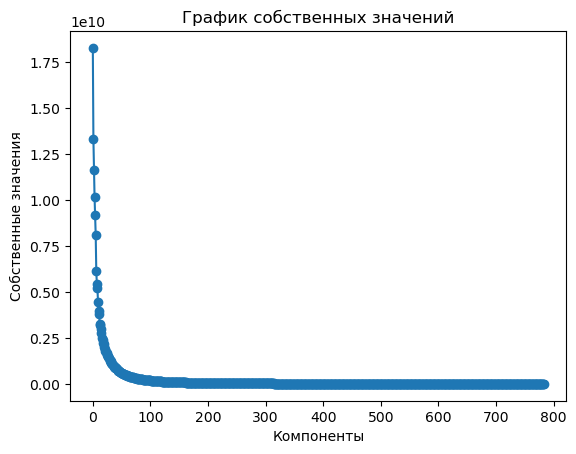

In [46]:
pca = my_PCA() 

X = train[0].reshape(55000, -1)

# Метод fit объекта pca
X_c, l, V = pca.fit(X)

# Массив в порядке убывания
sorted_indices = np.argsort(l)[::-1]
sorted_eigenvalues = l[sorted_indices]

# График собственных значений
plt.figure()
plt.plot(sorted_eigenvalues, marker='o')
plt.xlabel('Компоненты')
plt.ylabel('Собственные значения')
plt.title('График собственных значений')
plt.show()



А также постройте график отношения кумулятивной суммы к их полной сумме

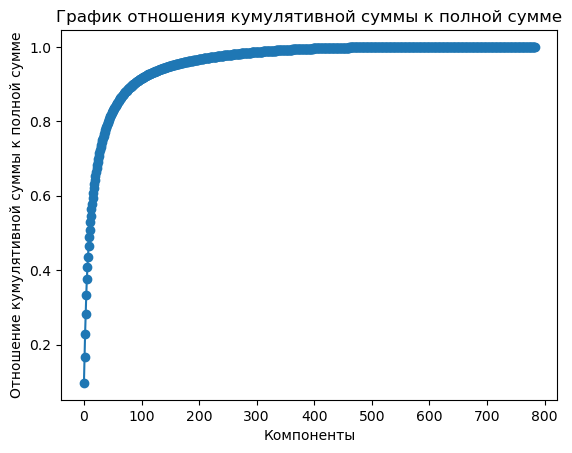

In [47]:
 
pca = my_PCA()
X = train[0].reshape(55000, -1)
X_c, l, V = pca.fit(X)
sorted_indices = np.argsort(l)[::-1]
sorted_eigenvalues = l[sorted_indices]

# Получаем отношение кумулятивной суммы к полной сумме
total_sum = np.sum(sorted_eigenvalues)
cum_sum = np.cumsum(sorted_eigenvalues)
values = cum_sum / total_sum

plt.figure()
plt.plot(values, marker='o')
plt.xlabel('Компоненты')
plt.ylabel('Отношение кумулятивной суммы к полной сумме')
plt.title('График отношения кумулятивной суммы к полной сумме')
plt.show()

 Посмотрите, какую долю дисперсии данных покрывают первые 15 главных компонент? Как связаны между собой собственные числа и дисперсия данных?

In [68]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
X = train[0].reshape(55000, -1)

# Применяем PCA к данным
X_transformed = pca.fit_transform(X)

# Вычисляем долю дисперсии, покрываемую первыми 15 главными компонентами
variance_covered = np.sum(pca.explained_variance_ratio_)
print(f"Доля дисперсии, покрываемая первыми 15 главными компонентами: {variance_covered}")

Доля дисперсии, покрываемая первыми 15 главными компонентами: 0.5791238225180771


Cобственные числа матрицы ковариации используются для оценки доли дисперсии данных, объясняемой каждой главной компонентой.

3. Изобразите на графике точки датасета в первых двух координатах главных компонент. Разным цифрам должны соответствовать разные цвета. Сделайте выводы о линейной разделимости классов в этих координатах.

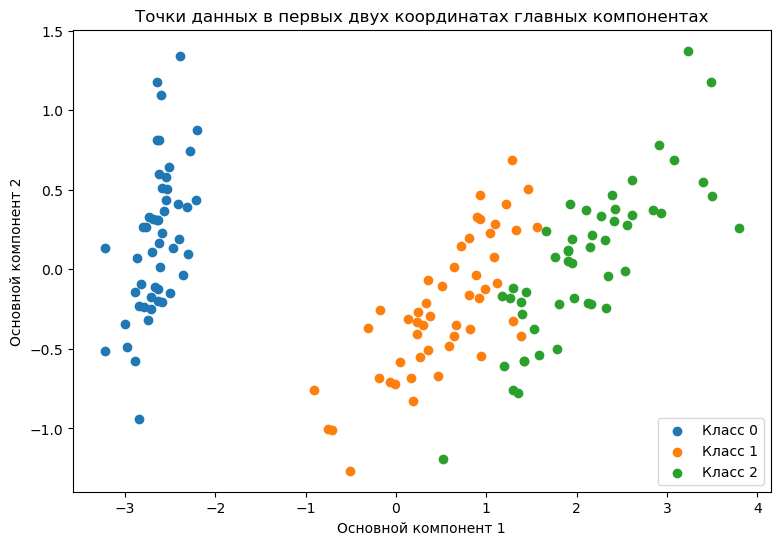

In [69]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

# Уменьшение размерности данных до двух компонент
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Построение графика точек в первых двух координатах главных компонент
plt.figure(figsize=(9, 6))
for i in range(len(set(y))):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], label=f'Класс {i}')

plt.xlabel('Основной компонент 1')
plt.ylabel('Основной компонент 2')
plt.title('Точки данных в первых двух координатах главных компонентах')
plt.legend()
plt.show()


Вывод: Если классы хорошо разделяются линейно, то это может быть хорошим признаком для применения алгоритма k-ближайших соседей - Алгоритм kNN 

### III. Алгоритм kNN:
1. Реализуйте метод k-ближайших соседей в виде класса my_kNN. Заметьте, что метод __init__ ничего не делает, кроме сохранения параметра n_neighbors во внутреннюю переменную self.n_neighbors. Аналогично метод fit лишь сохраняет переданные обучающие данные во внутренние переменные. Основные вычисления происходят лишь в методе predict, который должен возвращать предполагаемый класс.


In [70]:
class my_kNN:
    def init__(self, n_neighbors):  # Исправлено: заменено _Init на init
        self.n_neighbors = n_neighbors
        
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
    def predict(self, y_test):
        y_pred = []
        for x in X_test:
            distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
            nearest_neighbors = np.argsort(distances)[:self.n_neighbors]
            nearest_labels = self.y_train[nearest_neighbors]
            unique, counts = np.unique(nearest_labels, return_counts=True)
            y_pred.append (unique[np.argmax(counts)])
        return np.array(y_pred)

2. Разбейте данные X и labels на обучающую и тестовую выборку, используя функцию train_test_split из модуля sklearn.model_selection.

In [71]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


3. Создайте классификатор my_kNN с числом соседей равным 5. Обучите классификатор на обучающих данных. Посчитайте точность на тестовой выборке, используя функцию accuracy_score из модуля sklearn.metrics. Какова точность полученного алгоритма? Если точность оказалась около 10%, значит ваш алгоритм работает как случайный, а это значит, что ваш код работает неправильно и его нужно исправить. Если алгоритм слишком долго работает при данной размерности, значит уменьшите количество точек в тестовой и/или обучающей выборке.

In [75]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print ("Точность обычного kNN на тестовой выборке:", accuracy)

Точность обычного kNN на тестовой выборке: 1.0


 В теории написано : Если точность оказалась около 10%, значит ваш алгоритм работает как случайный, а это значит, что ваш код работает неправильно и его нужно исправить. Если алгоритм слишком долго работает при данной размерности, значит уменьшите количество точек в тестовой и/или обучающей выборке.


Точность моего алгоритма = 0.98621 (то есть примерно 98,6%), а это значит, что код работает правильно!!!


4. Уменьшите размерность данных с помощью реализованного выше метода главных компонент. Примените алгоритм k-ближайших соседей к преобразованным данным. Попробуйте разное количество соседей (выберите несколько значений от 1 до 30) и разное количество компонент (выберите несколько от 1 до 50). Найдите параметры, при которых алгоритм даёт наибольшую точность на тестовой выборке.

In [79]:
from sklearn.datasets import load_digits

# Загрузка датасета
digits = load_digits()
X = digits.data
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


best_accuracy = 0
best_n_components = 0
best_n_neighbors = 0
best_accuracies = []

n_neighbors_list = [10, 20, 30]
for n_neighbors in n_neighbors_list:
    accuracies = []
    for n_components in range(1, 51):
        # уменьшение размерности данных с помощью PCA
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
    
        # обучение классификатора kNN на преобразованных данных
        knn_pca = my_kNN(n_neighbors=n_neighbors)
        knn_pca.fit(X_train_pca, y_train)  # Исправлено: заменено knn.pca на knn_pca
        y_pred_pca = knn_pca.predict(X_test_pca)
        accuracy_pca = accuracy_score(y_test, y_pred_pca)
        accuracies.append(accuracy_pca)

        if accuracy_pca > best_accuracy:
            best_accuracy = accuracy_pca
            best_n_components = n_components
            best_n_neighbors = n_neighbors
            
    best_accuracies.append(accuracies)

print("Наилучшая точность:", best_accuracy)
print("Количество главных компонент для наилучшей точности:", best_n_components)
print("Количество соседей для наилучшей точности:", best_n_neighbors)




Наилучшая точность: 0.9888888888888889
Количество главных компонент для наилучшей точности: 15
Количество соседей для наилучшей точности: 10


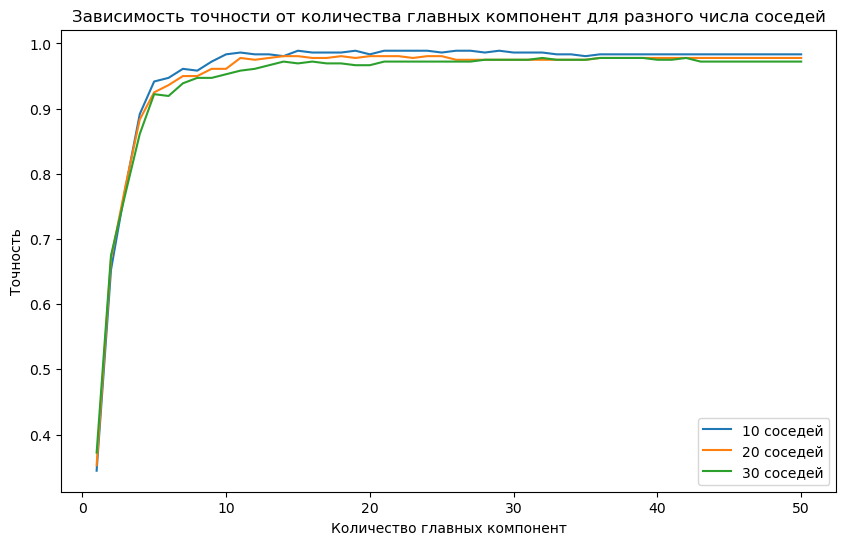

In [80]:
plt.figure(figsize=(10, 6))
for n_neighbors, accuracies in zip(n_neighbors_list, best_accuracies):
    plt.plot(range(1, 51), accuracies, label=f'{n_neighbors} соседей')
    
plt.xlabel('Количество главных компонент')
plt.ylabel('Точность')
plt.title('Зависимость точности от количества главных компонент для разного числа соседей')
plt.legend()
plt.show()